# *Importing Libraries:*
---

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Softmax, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam, Adamax, Nadam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# *Preprocessing:*
---

In [2]:
path = r'E:\ML Projects\05 Multi class Weather\Multi-class Weather Dataset'
folders = os.listdir(path)
print(folders)

['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,)

train_generator = datagen.flow_from_directory(
    path,
    target_size=(250,250),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    path,
    target_size=(250,250),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='validation')

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


### Show sample:

In [4]:
classes = list(train_generator.class_indices.keys())
img, lable = train_generator.next()
img.shape

(32, 250, 250, 3)

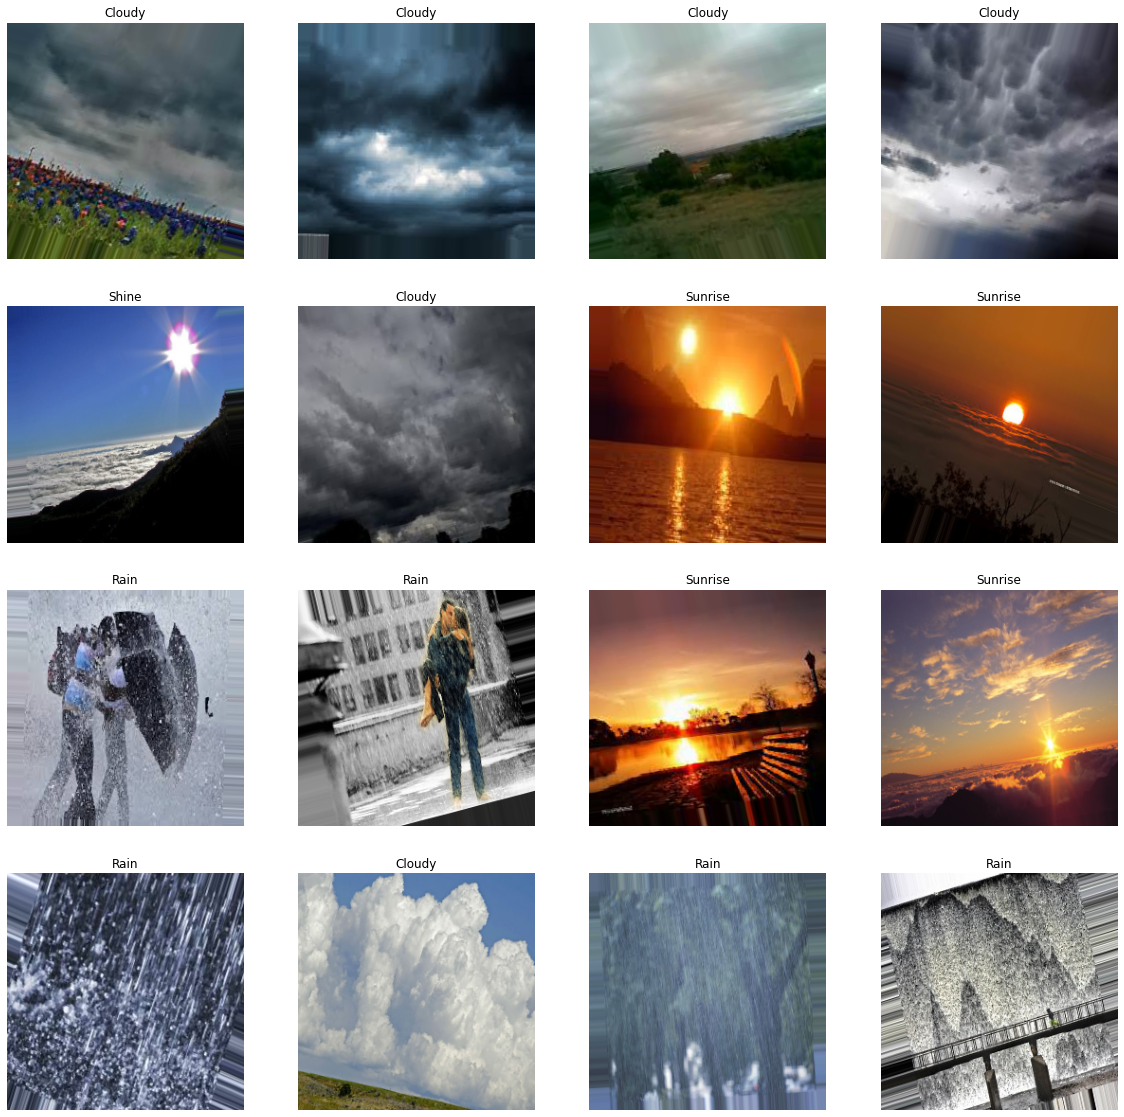

In [5]:
plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[i])
    index = np.argmax(lable[i]) 
    class_name = classes[index]
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [90]:
def draw_plot(history, history_ft = None, fine_tune = False):
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if not fine_tune:
        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy', color='darkblue')
        plt.plot(val_acc, label='Validation Accuracy', color='deeppink')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()), 1])
        plt.xlim([-1, initial_epochs + 1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss', color='darkblue')
        plt.plot(val_loss, label='Validation Loss', color='deeppink')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0, 1.0])
        plt.xlim([-1, initial_epochs + 1])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()
    else:
        acc += history_ft.history['accuracy']
        val_acc += history_ft.history['val_accuracy']

        loss += history_ft.history['loss']
        val_loss += history_ft.history['val_loss']
        
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy', color='darkblue')
        plt.plot(val_acc, label='Validation Accuracy', color='deeppink')
        plt.ylim([0.7, 1])
        plt.xlim([-1, initial_epochs + fine_tune_epochs + 1])
        plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Start Fine Tuning', color='g')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss', color='darkblue')
        plt.plot(val_loss, label='Validation Loss', color='deeppink')
        plt.ylim([0, 1.0])
        plt.xlim([-1, initial_epochs + fine_tune_epochs + 1])
        plt.plot([initial_epochs, initial_epochs], plt.ylim(), label='Start Fine Tuning', color='g')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()
        
def print_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y.classes, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Cloudy', 'Rain', 'Shine', 'Sunrise'])
    cmd.plot()
    plt.xlabel('Predicted Values', fontsize = 12)
    plt.ylabel('Actual Values', fontsize = 12)
    plt.show()

# *Model Structure:*
---

In [45]:
# global parameters:
initial_epochs = 15
fine_tune_epochs = 10
input_shape = (250, 250, 3)

LR = 1e-3
OPTIMIZER = Adamax(LR)
LOSS = CategoricalCrossentropy()
METRICS = ['accuracy']

## Dense Neural Network:

In [33]:
model_dnn = Sequential([
    Input(shape=(250, 250, 3)),
    Flatten(),
    
    Dense(128, 'relu'),
    BatchNormalization(),
    
    Dense(64, 'relu'),
    BatchNormalization(),
    
    Dense(32, 'relu'),
    BatchNormalization(),
    
    Dense(16, 'relu'),
    BatchNormalization(),
    
    Dense(8, 'relu'),
    BatchNormalization(),
    
    Dense(4, 'softmax')
])

model_dnn.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [7]:
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 187500)            0         
                                                                 
 dense (Dense)               (None, 128)               24000128  
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                2

In [8]:
hist_dnn = model_dnn.fit(train_generator, validation_data = validation_generator, epochs = 10, verbose = 2)

Epoch 1/10
29/29 - 21s - loss: 0.6363 - accuracy: 0.5483 - val_loss: 2.0318 - val_accuracy: 0.2321 - 21s/epoch - 731ms/step
Epoch 2/10
29/29 - 17s - loss: 0.5466 - accuracy: 0.7092 - val_loss: 1.3038 - val_accuracy: 0.2902 - 17s/epoch - 569ms/step
Epoch 3/10
29/29 - 17s - loss: 0.4964 - accuracy: 0.7525 - val_loss: 0.9672 - val_accuracy: 0.3170 - 17s/epoch - 588ms/step
Epoch 4/10
29/29 - 18s - loss: 0.4564 - accuracy: 0.7847 - val_loss: 0.6599 - val_accuracy: 0.5045 - 18s/epoch - 632ms/step
Epoch 5/10
29/29 - 18s - loss: 0.4327 - accuracy: 0.7791 - val_loss: 0.5759 - val_accuracy: 0.6250 - 18s/epoch - 606ms/step
Epoch 6/10
29/29 - 17s - loss: 0.4015 - accuracy: 0.7980 - val_loss: 0.5879 - val_accuracy: 0.6116 - 17s/epoch - 602ms/step
Epoch 7/10
29/29 - 18s - loss: 0.3773 - accuracy: 0.8169 - val_loss: 0.4702 - val_accuracy: 0.7455 - 18s/epoch - 621ms/step
Epoch 8/10
29/29 - 17s - loss: 0.3589 - accuracy: 0.8246 - val_loss: 0.4949 - val_accuracy: 0.6384 - 17s/epoch - 596ms/step
Epoch 9/

# *Convolutional Neural Network:*
### *Using Transfer Learning*
---

## InceptionV3:

In [ ]:
###############################
tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, 
                                                  weights= "imagenet", 
                                                  input_shape= img_shape, 
                                                  pooling= 'max')
###############################

In [30]:
base_model_inc = tf.keras.applications.InceptionV3(input_shape = input_shape,
                                                   include_top = False,
                                                   weights = "imagenet"
                                                  )

In [31]:
base_model_inc.trainable = False

In [34]:
model_inc = Sequential([
    base_model_inc,
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(64, 'relu'),
    BatchNormalization(),
    Dense(len(classes), "softmax")
])

model_inc.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [35]:
model_inc.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 3, 3, 2048)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_138 (B  (None, 3, 3, 2048)        8192      
 atchNormalization)                                              
                                                                 
 flatten_11 (Flatten)        (None, 18432)             0         
                                                                 
 dense_30 (Dense)            (None, 64)                1179712   
                                                                 
 batch_normalization_139 (B  (None, 64)              

In [36]:
len(model_inc.trainable_variables)

8

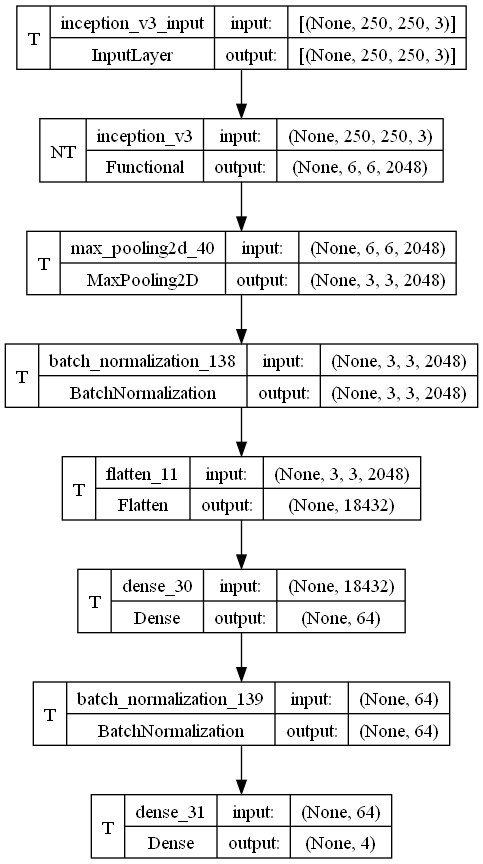

In [37]:
plot_model(model_inc, show_shapes = True, show_trainable = True)

In [38]:
hist_inc = model_inc.fit(train_generator, validation_data = validation_generator, epochs = initial_epochs, verbose = 2)

Epoch 1/15
29/29 - 44s - loss: 0.4585 - accuracy: 0.8224 - val_loss: 0.7911 - val_accuracy: 0.8125 - 44s/epoch - 2s/step
Epoch 2/15
29/29 - 39s - loss: 0.1968 - accuracy: 0.9390 - val_loss: 0.3566 - val_accuracy: 0.9062 - 39s/epoch - 1s/step
Epoch 3/15
29/29 - 38s - loss: 0.1504 - accuracy: 0.9478 - val_loss: 0.2495 - val_accuracy: 0.9107 - 38s/epoch - 1s/step
Epoch 4/15
29/29 - 38s - loss: 0.1176 - accuracy: 0.9656 - val_loss: 0.2804 - val_accuracy: 0.9018 - 38s/epoch - 1s/step
Epoch 5/15
29/29 - 37s - loss: 0.0944 - accuracy: 0.9723 - val_loss: 0.2368 - val_accuracy: 0.9152 - 37s/epoch - 1s/step
Epoch 6/15
29/29 - 37s - loss: 0.0987 - accuracy: 0.9767 - val_loss: 0.2713 - val_accuracy: 0.9062 - 37s/epoch - 1s/step
Epoch 7/15
29/29 - 37s - loss: 0.0868 - accuracy: 0.9734 - val_loss: 0.1874 - val_accuracy: 0.9241 - 37s/epoch - 1s/step
Epoch 8/15
29/29 - 38s - loss: 0.0759 - accuracy: 0.9778 - val_loss: 0.1779 - val_accuracy: 0.9330 - 38s/epoch - 1s/step
Epoch 9/15
29/29 - 38s - loss: 0

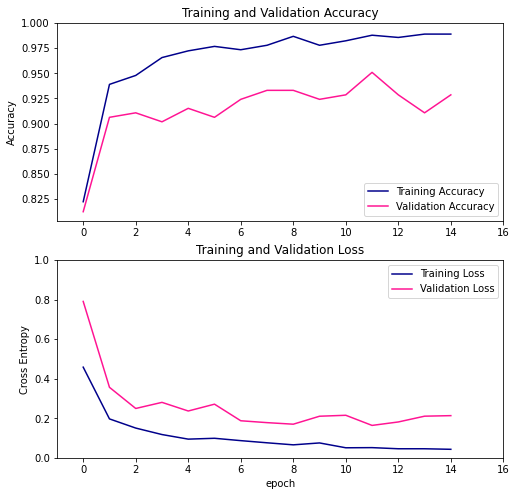

In [41]:
draw_plot(hist_inc)

## Fine Tuning

In [42]:
base_model_inc.trainable = True
print("Number of layers in the base model: ", len(base_model_inc.layers))

Number of layers in the base model:  311


In [43]:
fine_tune_at = 250

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_inc.layers[:fine_tune_at]:
    layer.trainable = False

In [46]:
LR = LR / 10
model_inc.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [47]:
model_inc.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 3, 3, 2048)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_138 (B  (None, 3, 3, 2048)        8192      
 atchNormalization)                                              
                                                                 
 flatten_11 (Flatten)        (None, 18432)             0         
                                                                 
 dense_30 (Dense)            (None, 64)                1179712   
                                                                 
 batch_normalization_139 (B  (None, 64)              

In [48]:
len(model_inc.trainable_variables)

43

In [49]:
total_epochs =  initial_epochs + fine_tune_epochs

hist_inc_fine = model_inc.fit(train_generator, 
                              validation_data = validation_generator, 
                              epochs = total_epochs, 
                              initial_epoch = hist_inc.epoch[-1],
                              verbose = 2)

Epoch 15/25
29/29 - 54s - loss: 0.2696 - accuracy: 0.9190 - val_loss: 0.6104 - val_accuracy: 0.8661 - 54s/epoch - 2s/step
Epoch 16/25
29/29 - 47s - loss: 0.0688 - accuracy: 0.9789 - val_loss: 0.7303 - val_accuracy: 0.8705 - 47s/epoch - 2s/step
Epoch 17/25
29/29 - 47s - loss: 0.0656 - accuracy: 0.9834 - val_loss: 0.4124 - val_accuracy: 0.8705 - 47s/epoch - 2s/step
Epoch 18/25
29/29 - 48s - loss: 0.0503 - accuracy: 0.9822 - val_loss: 0.4364 - val_accuracy: 0.9018 - 48s/epoch - 2s/step
Epoch 19/25
29/29 - 48s - loss: 0.0441 - accuracy: 0.9889 - val_loss: 0.2556 - val_accuracy: 0.9241 - 48s/epoch - 2s/step
Epoch 20/25
29/29 - 48s - loss: 0.0307 - accuracy: 0.9889 - val_loss: 0.2342 - val_accuracy: 0.9375 - 48s/epoch - 2s/step
Epoch 21/25
29/29 - 48s - loss: 0.0413 - accuracy: 0.9867 - val_loss: 0.1978 - val_accuracy: 0.9375 - 48s/epoch - 2s/step
Epoch 22/25
29/29 - 48s - loss: 0.0207 - accuracy: 0.9911 - val_loss: 0.2046 - val_accuracy: 0.9375 - 48s/epoch - 2s/step
Epoch 23/25
29/29 - 48s 

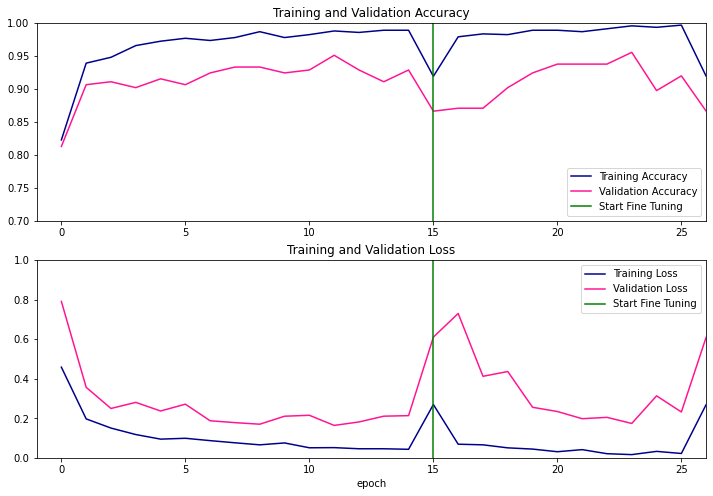

In [58]:
draw_plot(hist_inc, hist_inc_fine, fine_tune = True)

## Evaluation

In [81]:
loss, accuracy = model.evaluate(validation_generator)
print('Test accuracy :', accuracy * 100)

7/7 [==============================] - 8s 1s/step - loss: 0.2114 - accuracy: 0.9286
Test accuracy : 92.85714030265808


## Get Predictions

In [86]:
preds = model_inc.predict(validation_generator)
y_pred = np.argmax(preds, axis=1)

7/7 [==============================] - 9s 1s/step


## Confusion Matrics 

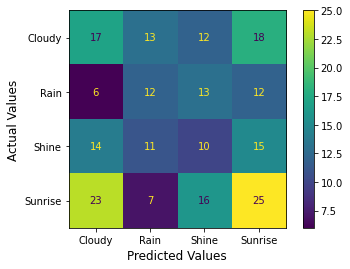

In [89]:
print_confusion_matrix(validation_generator, y_pred)

## Classification Report

In [88]:
print(classification_report(validation_generator.classes, y_pred, target_names= ['Cloudy', 'Rain', 'Shine', 'Sunrise']))

              precision    recall  f1-score   support

      Cloudy       0.28      0.28      0.28        60
        Rain       0.28      0.28      0.28        43
       Shine       0.20      0.20      0.20        50
     Sunrise       0.36      0.35      0.35        71

    accuracy                           0.29       224
   macro avg       0.28      0.28      0.28       224
weighted avg       0.29      0.29      0.29       224



## Save Model

In [ ]:
model_inc.save('model_inc.h5')